# Data Science | Final Project | Group 02

## Identify epigenetic alterations associated with Alzheimer’s disease and classification of gene expressions between healthy and sick patients

#### Christina Kirschbaum, Pushpa Koirala, Melika Moradi

## Our Project

Alzheimer’s disease is the most prevalent kind of dementia and a fatal brain ailment. More study into this illness might lead to a better understanding of the condition and more effective treatment options. 

In this project, ChIP-seq data for H3K27ac, H3K9ac, H3K122ac and H3K4me1 as well as RNA-seq data from the from the lateral temporal lobe of the human brain for young healthy patients, old heathy patients and patients with Alzheimers disease will be analyzed and the differences between normal aging and cognitive impairment will be explored. The epigenomic or transcriptomic profiles will be analyzed to find relevant epigenetic alterations associated with the disease and help to better understand the molecular pathophysiology underlying.

Afterwards, with Machine Learning models the presence and absence of Alzheimer’s disease based on the data. The models will be built with Support Vector Machines and Random Forest.

Finally, the findings will be compared to them in related papers, we will look into relevant *in vivo* experiments with model organisms and use the Genome Browser to generate ChIP-seq tracks.

For our project we were inspirated by the paper:
Nativio R, Lan Y, Donahue G et al. ["An integrated multi-omics approach identifies
epigenetic alterations associated with Alzheimer’s disease."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8098004/)

The data is derived from GEO, [Series GSE153875](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE153875), for the CHiP-seq data and the raw RNA-seq data [Series GSE159699](https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA670209&o=acc_s%3Aa). 

## Data Integration and Preprocessing RNA-seq

In the next step, we import our RNA-seq data from the SubSeries GSE159699 of the SuperSeries GSE153875 with SRA-Toolkit and fastq-dump. To integrate this process into Python, the package subrocess is used.

In [3]:
import subprocess

# sra numbers from accession list of our RNA-seq data from SuperSeries GSE153875 / SubSeries GSE159699
sra_numbers = [
    "SRR12850830", "SRR12850831", "SRR12850832", "SRR12850833", "SRR12850834",
    "SRR12850835", "SRR12850836", "SRR12850837", "SRR12850838", "SRR12850839",
    "SRR12850840", "SRR12850841", "SRR12850842", "SRR12850843", "SRR12850844",
    "SRR12850845", "SRR12850846", "SRR12850847", "SRR12850848", "SRR12850849",
    "SRR12850850", "SRR12850851", "SRR12850852", "SRR12850853", "SRR12850854",
    "SRR12850855", "SRR12850856", "SRR12850857", "SRR12850858", "SRR12850859"
    ]

In [ ]:
# code from https://erilu.github.io/python-fastq-downloader/

# this will download the .sra files to ~/ncbi/public/sra/ 
for sra_id in sra_numbers:
    print ("Currently downloading: " + sra_id)
    prefetch = "prefetch " + sra_id
    print ("The command used was: " + prefetch)
    subprocess.call(prefetch, shell=True)

# this will extract the .sra files from above into a folder named 'fastq'
for sra_id in sra_numbers:
    print ("Generating fastq for: " + sra_id)
    fastq_dump = "fastq-dump --outdir fastq --gzip --skip-technical  --readids --read-filter pass --dumpbase --split-3 --clip ~/ncbi/public/sra/" + sra_id + ".sra"
    print ("The command used was: " + fastq_dump)
    subprocess.call(fastq_dump, shell=True)

## Data Integration for ChIP-seq

The .bed and .bw files for the ChIP-seq data were downloaded. They are available as supplementary files of the SuperSeries GSE153875 from GEO. We split them into folders for H3K27ac, H3K9ac, H3K122ac and H3K4me1 (and peaks) to get smaller sets.

In [ ]:
# The following code can get the metadata (if needed) for the ChIP-seq data with the library GEOparse (similar to GEOquery).
import GEOparse

gse = GEOparse.get_GEO(geo="GSE153875", destdir="./")

In [ ]:
# prints the metadata for the first sample
for gsm_name, gsm in gse.gsms.items():
    print("Name: ", gsm_name)
    print("Metadata:",)
    for key, value in gsm.metadata.items():
        print(" - %s : %s" % (key, ", ".join(value)))
    break

## Quality Control RNA-seq

### FastQC

For the Quality Control of the RNA-seq data, [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) was downloaded and reports were generated for every sequence. The reports can be found in the repository in the folder MultiQC_RNA.

In [1]:
import subprocess

path = "/mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/"
path_genomeDir = "/mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/GenomeDir/"
path_fastq = "/mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/fastq/"

In [ ]:
# unzip data
for fastq in sra_numbers:
    gunzip = "gunzip " + path_fastq + fastq + "_pass.fastq.gz"
    subprocess.call(gunzip, shell=True)

In [5]:
for fastq in sra_numbers:
    fastqc = "/home/christina/FastQC/fastqc \
              --readFilesIn " + path_fastq + fastq + "_pass.fastq"
    subprocess.call(fastqc, shell=True)

Unknown option: readfilesin
Started analysis of SRR12850830_pass.fastq
Approx 5% complete for SRR12850830_pass.fastq
Approx 10% complete for SRR12850830_pass.fastq
Approx 15% complete for SRR12850830_pass.fastq
Approx 20% complete for SRR12850830_pass.fastq
Approx 25% complete for SRR12850830_pass.fastq
Approx 30% complete for SRR12850830_pass.fastq
Approx 35% complete for SRR12850830_pass.fastq
Approx 40% complete for SRR12850830_pass.fastq
Approx 45% complete for SRR12850830_pass.fastq
Approx 50% complete for SRR12850830_pass.fastq
Approx 55% complete for SRR12850830_pass.fastq
Approx 60% complete for SRR12850830_pass.fastq
Approx 65% complete for SRR12850830_pass.fastq
Approx 70% complete for SRR12850830_pass.fastq
Approx 75% complete for SRR12850830_pass.fastq
Approx 80% complete for SRR12850830_pass.fastq
Approx 85% complete for SRR12850830_pass.fastq
Approx 90% complete for SRR12850830_pass.fastq
Approx 95% complete for SRR12850830_pass.fastq


Analysis complete for SRR12850830_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850831_pass.fastq
Approx 5% complete for SRR12850831_pass.fastq
Approx 10% complete for SRR12850831_pass.fastq
Approx 15% complete for SRR12850831_pass.fastq
Approx 20% complete for SRR12850831_pass.fastq
Approx 25% complete for SRR12850831_pass.fastq
Approx 30% complete for SRR12850831_pass.fastq
Approx 35% complete for SRR12850831_pass.fastq
Approx 40% complete for SRR12850831_pass.fastq
Approx 45% complete for SRR12850831_pass.fastq
Approx 50% complete for SRR12850831_pass.fastq
Approx 55% complete for SRR12850831_pass.fastq
Approx 60% complete for SRR12850831_pass.fastq
Approx 65% complete for SRR12850831_pass.fastq
Approx 70% complete for SRR12850831_pass.fastq
Approx 75% complete for SRR12850831_pass.fastq
Approx 80% complete for SRR12850831_pass.fastq
Approx 85% complete for SRR12850831_pass.fastq
Approx 90% complete for SRR12850831_pass.fastq
Approx 95% complete for SRR12850831_pass.fastq


Analysis complete for SRR12850831_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850832_pass.fastq
Approx 5% complete for SRR12850832_pass.fastq
Approx 10% complete for SRR12850832_pass.fastq
Approx 15% complete for SRR12850832_pass.fastq
Approx 20% complete for SRR12850832_pass.fastq
Approx 25% complete for SRR12850832_pass.fastq
Approx 30% complete for SRR12850832_pass.fastq
Approx 35% complete for SRR12850832_pass.fastq
Approx 40% complete for SRR12850832_pass.fastq
Approx 45% complete for SRR12850832_pass.fastq
Approx 50% complete for SRR12850832_pass.fastq
Approx 55% complete for SRR12850832_pass.fastq
Approx 60% complete for SRR12850832_pass.fastq
Approx 65% complete for SRR12850832_pass.fastq
Approx 70% complete for SRR12850832_pass.fastq
Approx 75% complete for SRR12850832_pass.fastq
Approx 80% complete for SRR12850832_pass.fastq
Approx 85% complete for SRR12850832_pass.fastq
Approx 90% complete for SRR12850832_pass.fastq
Approx 95% complete for SRR12850832_pass.fastq


Analysis complete for SRR12850832_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850833_pass.fastq
Approx 5% complete for SRR12850833_pass.fastq
Approx 10% complete for SRR12850833_pass.fastq
Approx 15% complete for SRR12850833_pass.fastq
Approx 20% complete for SRR12850833_pass.fastq
Approx 25% complete for SRR12850833_pass.fastq
Approx 30% complete for SRR12850833_pass.fastq
Approx 35% complete for SRR12850833_pass.fastq
Approx 40% complete for SRR12850833_pass.fastq
Approx 45% complete for SRR12850833_pass.fastq
Approx 50% complete for SRR12850833_pass.fastq
Approx 55% complete for SRR12850833_pass.fastq
Approx 60% complete for SRR12850833_pass.fastq
Approx 65% complete for SRR12850833_pass.fastq
Approx 70% complete for SRR12850833_pass.fastq
Approx 75% complete for SRR12850833_pass.fastq
Approx 80% complete for SRR12850833_pass.fastq
Approx 85% complete for SRR12850833_pass.fastq
Approx 90% complete for SRR12850833_pass.fastq
Approx 95% complete for SRR12850833_pass.fastq


Analysis complete for SRR12850833_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850834_pass.fastq
Approx 5% complete for SRR12850834_pass.fastq
Approx 10% complete for SRR12850834_pass.fastq
Approx 15% complete for SRR12850834_pass.fastq
Approx 20% complete for SRR12850834_pass.fastq
Approx 25% complete for SRR12850834_pass.fastq
Approx 30% complete for SRR12850834_pass.fastq
Approx 35% complete for SRR12850834_pass.fastq
Approx 40% complete for SRR12850834_pass.fastq
Approx 45% complete for SRR12850834_pass.fastq
Approx 50% complete for SRR12850834_pass.fastq
Approx 55% complete for SRR12850834_pass.fastq
Approx 60% complete for SRR12850834_pass.fastq
Approx 65% complete for SRR12850834_pass.fastq
Approx 70% complete for SRR12850834_pass.fastq
Approx 75% complete for SRR12850834_pass.fastq
Approx 80% complete for SRR12850834_pass.fastq
Approx 85% complete for SRR12850834_pass.fastq
Approx 90% complete for SRR12850834_pass.fastq
Approx 95% complete for SRR12850834_pass.fastq


Analysis complete for SRR12850834_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850835_pass.fastq
Approx 5% complete for SRR12850835_pass.fastq
Approx 10% complete for SRR12850835_pass.fastq
Approx 15% complete for SRR12850835_pass.fastq
Approx 20% complete for SRR12850835_pass.fastq
Approx 25% complete for SRR12850835_pass.fastq
Approx 30% complete for SRR12850835_pass.fastq
Approx 35% complete for SRR12850835_pass.fastq
Approx 40% complete for SRR12850835_pass.fastq
Approx 45% complete for SRR12850835_pass.fastq
Approx 50% complete for SRR12850835_pass.fastq
Approx 55% complete for SRR12850835_pass.fastq
Approx 60% complete for SRR12850835_pass.fastq
Approx 65% complete for SRR12850835_pass.fastq
Approx 70% complete for SRR12850835_pass.fastq
Approx 75% complete for SRR12850835_pass.fastq
Approx 80% complete for SRR12850835_pass.fastq
Approx 85% complete for SRR12850835_pass.fastq
Approx 90% complete for SRR12850835_pass.fastq
Approx 95% complete for SRR12850835_pass.fastq


Analysis complete for SRR12850835_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850836_pass.fastq
Approx 5% complete for SRR12850836_pass.fastq
Approx 10% complete for SRR12850836_pass.fastq
Approx 15% complete for SRR12850836_pass.fastq
Approx 20% complete for SRR12850836_pass.fastq
Approx 25% complete for SRR12850836_pass.fastq
Approx 30% complete for SRR12850836_pass.fastq
Approx 35% complete for SRR12850836_pass.fastq
Approx 40% complete for SRR12850836_pass.fastq
Approx 45% complete for SRR12850836_pass.fastq
Approx 50% complete for SRR12850836_pass.fastq
Approx 55% complete for SRR12850836_pass.fastq
Approx 60% complete for SRR12850836_pass.fastq
Approx 65% complete for SRR12850836_pass.fastq
Approx 70% complete for SRR12850836_pass.fastq
Approx 75% complete for SRR12850836_pass.fastq
Approx 80% complete for SRR12850836_pass.fastq
Approx 85% complete for SRR12850836_pass.fastq
Approx 90% complete for SRR12850836_pass.fastq
Approx 95% complete for SRR12850836_pass.fastq


Analysis complete for SRR12850836_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850837_pass.fastq
Approx 5% complete for SRR12850837_pass.fastq
Approx 10% complete for SRR12850837_pass.fastq
Approx 15% complete for SRR12850837_pass.fastq
Approx 20% complete for SRR12850837_pass.fastq
Approx 25% complete for SRR12850837_pass.fastq
Approx 30% complete for SRR12850837_pass.fastq
Approx 35% complete for SRR12850837_pass.fastq
Approx 40% complete for SRR12850837_pass.fastq
Approx 45% complete for SRR12850837_pass.fastq
Approx 50% complete for SRR12850837_pass.fastq
Approx 55% complete for SRR12850837_pass.fastq
Approx 60% complete for SRR12850837_pass.fastq
Approx 65% complete for SRR12850837_pass.fastq
Approx 70% complete for SRR12850837_pass.fastq
Approx 75% complete for SRR12850837_pass.fastq
Approx 80% complete for SRR12850837_pass.fastq
Approx 85% complete for SRR12850837_pass.fastq
Approx 90% complete for SRR12850837_pass.fastq
Approx 95% complete for SRR12850837_pass.fastq


Analysis complete for SRR12850837_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850838_pass.fastq
Approx 5% complete for SRR12850838_pass.fastq
Approx 10% complete for SRR12850838_pass.fastq
Approx 15% complete for SRR12850838_pass.fastq
Approx 20% complete for SRR12850838_pass.fastq
Approx 25% complete for SRR12850838_pass.fastq
Approx 30% complete for SRR12850838_pass.fastq
Approx 35% complete for SRR12850838_pass.fastq
Approx 40% complete for SRR12850838_pass.fastq
Approx 45% complete for SRR12850838_pass.fastq
Approx 50% complete for SRR12850838_pass.fastq
Approx 55% complete for SRR12850838_pass.fastq
Approx 60% complete for SRR12850838_pass.fastq
Approx 65% complete for SRR12850838_pass.fastq
Approx 70% complete for SRR12850838_pass.fastq
Approx 75% complete for SRR12850838_pass.fastq
Approx 80% complete for SRR12850838_pass.fastq
Approx 85% complete for SRR12850838_pass.fastq
Approx 90% complete for SRR12850838_pass.fastq
Approx 95% complete for SRR12850838_pass.fastq


Analysis complete for SRR12850838_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850839_pass.fastq
Approx 5% complete for SRR12850839_pass.fastq
Approx 10% complete for SRR12850839_pass.fastq
Approx 15% complete for SRR12850839_pass.fastq
Approx 20% complete for SRR12850839_pass.fastq
Approx 25% complete for SRR12850839_pass.fastq
Approx 30% complete for SRR12850839_pass.fastq
Approx 35% complete for SRR12850839_pass.fastq
Approx 40% complete for SRR12850839_pass.fastq
Approx 45% complete for SRR12850839_pass.fastq
Approx 50% complete for SRR12850839_pass.fastq
Approx 55% complete for SRR12850839_pass.fastq
Approx 60% complete for SRR12850839_pass.fastq
Approx 65% complete for SRR12850839_pass.fastq
Approx 70% complete for SRR12850839_pass.fastq
Approx 75% complete for SRR12850839_pass.fastq
Approx 80% complete for SRR12850839_pass.fastq
Approx 85% complete for SRR12850839_pass.fastq
Approx 90% complete for SRR12850839_pass.fastq
Approx 95% complete for SRR12850839_pass.fastq


Analysis complete for SRR12850839_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850840_pass.fastq
Approx 5% complete for SRR12850840_pass.fastq
Approx 10% complete for SRR12850840_pass.fastq
Approx 15% complete for SRR12850840_pass.fastq
Approx 20% complete for SRR12850840_pass.fastq
Approx 25% complete for SRR12850840_pass.fastq
Approx 30% complete for SRR12850840_pass.fastq
Approx 35% complete for SRR12850840_pass.fastq
Approx 40% complete for SRR12850840_pass.fastq
Approx 45% complete for SRR12850840_pass.fastq
Approx 50% complete for SRR12850840_pass.fastq
Approx 55% complete for SRR12850840_pass.fastq
Approx 60% complete for SRR12850840_pass.fastq
Approx 65% complete for SRR12850840_pass.fastq
Approx 70% complete for SRR12850840_pass.fastq
Approx 75% complete for SRR12850840_pass.fastq
Approx 80% complete for SRR12850840_pass.fastq
Approx 85% complete for SRR12850840_pass.fastq
Approx 90% complete for SRR12850840_pass.fastq
Approx 95% complete for SRR12850840_pass.fastq


Analysis complete for SRR12850840_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850841_pass.fastq
Approx 5% complete for SRR12850841_pass.fastq
Approx 10% complete for SRR12850841_pass.fastq
Approx 15% complete for SRR12850841_pass.fastq
Approx 20% complete for SRR12850841_pass.fastq
Approx 25% complete for SRR12850841_pass.fastq
Approx 30% complete for SRR12850841_pass.fastq
Approx 35% complete for SRR12850841_pass.fastq
Approx 40% complete for SRR12850841_pass.fastq
Approx 45% complete for SRR12850841_pass.fastq
Approx 50% complete for SRR12850841_pass.fastq
Approx 55% complete for SRR12850841_pass.fastq
Approx 60% complete for SRR12850841_pass.fastq
Approx 65% complete for SRR12850841_pass.fastq
Approx 70% complete for SRR12850841_pass.fastq
Approx 75% complete for SRR12850841_pass.fastq
Approx 80% complete for SRR12850841_pass.fastq
Approx 85% complete for SRR12850841_pass.fastq
Approx 90% complete for SRR12850841_pass.fastq
Approx 95% complete for SRR12850841_pass.fastq


Analysis complete for SRR12850841_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850842_pass.fastq
Approx 5% complete for SRR12850842_pass.fastq
Approx 10% complete for SRR12850842_pass.fastq
Approx 15% complete for SRR12850842_pass.fastq
Approx 20% complete for SRR12850842_pass.fastq
Approx 25% complete for SRR12850842_pass.fastq
Approx 30% complete for SRR12850842_pass.fastq
Approx 35% complete for SRR12850842_pass.fastq
Approx 40% complete for SRR12850842_pass.fastq
Approx 45% complete for SRR12850842_pass.fastq
Approx 50% complete for SRR12850842_pass.fastq
Approx 55% complete for SRR12850842_pass.fastq
Approx 60% complete for SRR12850842_pass.fastq
Approx 65% complete for SRR12850842_pass.fastq
Approx 70% complete for SRR12850842_pass.fastq
Approx 75% complete for SRR12850842_pass.fastq
Approx 80% complete for SRR12850842_pass.fastq
Approx 85% complete for SRR12850842_pass.fastq
Approx 90% complete for SRR12850842_pass.fastq
Approx 95% complete for SRR12850842_pass.fastq


Analysis complete for SRR12850842_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850843_pass.fastq
Approx 5% complete for SRR12850843_pass.fastq
Approx 10% complete for SRR12850843_pass.fastq
Approx 15% complete for SRR12850843_pass.fastq
Approx 20% complete for SRR12850843_pass.fastq
Approx 25% complete for SRR12850843_pass.fastq
Approx 30% complete for SRR12850843_pass.fastq
Approx 35% complete for SRR12850843_pass.fastq
Approx 40% complete for SRR12850843_pass.fastq
Approx 45% complete for SRR12850843_pass.fastq
Approx 50% complete for SRR12850843_pass.fastq
Approx 55% complete for SRR12850843_pass.fastq
Approx 60% complete for SRR12850843_pass.fastq
Approx 65% complete for SRR12850843_pass.fastq
Approx 70% complete for SRR12850843_pass.fastq
Approx 75% complete for SRR12850843_pass.fastq
Approx 80% complete for SRR12850843_pass.fastq
Approx 85% complete for SRR12850843_pass.fastq
Approx 90% complete for SRR12850843_pass.fastq
Approx 95% complete for SRR12850843_pass.fastq


Analysis complete for SRR12850843_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850844_pass.fastq
Approx 5% complete for SRR12850844_pass.fastq
Approx 10% complete for SRR12850844_pass.fastq
Approx 15% complete for SRR12850844_pass.fastq
Approx 20% complete for SRR12850844_pass.fastq
Approx 25% complete for SRR12850844_pass.fastq
Approx 30% complete for SRR12850844_pass.fastq
Approx 35% complete for SRR12850844_pass.fastq
Approx 40% complete for SRR12850844_pass.fastq
Approx 45% complete for SRR12850844_pass.fastq
Approx 50% complete for SRR12850844_pass.fastq
Approx 55% complete for SRR12850844_pass.fastq
Approx 60% complete for SRR12850844_pass.fastq
Approx 65% complete for SRR12850844_pass.fastq
Approx 70% complete for SRR12850844_pass.fastq
Approx 75% complete for SRR12850844_pass.fastq
Approx 80% complete for SRR12850844_pass.fastq
Approx 85% complete for SRR12850844_pass.fastq
Approx 90% complete for SRR12850844_pass.fastq
Approx 95% complete for SRR12850844_pass.fastq


Analysis complete for SRR12850844_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850845_pass.fastq
Approx 5% complete for SRR12850845_pass.fastq
Approx 10% complete for SRR12850845_pass.fastq
Approx 15% complete for SRR12850845_pass.fastq
Approx 20% complete for SRR12850845_pass.fastq
Approx 25% complete for SRR12850845_pass.fastq
Approx 30% complete for SRR12850845_pass.fastq
Approx 35% complete for SRR12850845_pass.fastq
Approx 40% complete for SRR12850845_pass.fastq
Approx 45% complete for SRR12850845_pass.fastq
Approx 50% complete for SRR12850845_pass.fastq
Approx 55% complete for SRR12850845_pass.fastq
Approx 60% complete for SRR12850845_pass.fastq
Approx 65% complete for SRR12850845_pass.fastq
Approx 70% complete for SRR12850845_pass.fastq
Approx 75% complete for SRR12850845_pass.fastq
Approx 80% complete for SRR12850845_pass.fastq
Approx 85% complete for SRR12850845_pass.fastq
Approx 90% complete for SRR12850845_pass.fastq
Approx 95% complete for SRR12850845_pass.fastq


Analysis complete for SRR12850845_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850846_pass.fastq
Approx 5% complete for SRR12850846_pass.fastq
Approx 10% complete for SRR12850846_pass.fastq
Approx 15% complete for SRR12850846_pass.fastq
Approx 20% complete for SRR12850846_pass.fastq
Approx 25% complete for SRR12850846_pass.fastq
Approx 30% complete for SRR12850846_pass.fastq
Approx 35% complete for SRR12850846_pass.fastq
Approx 40% complete for SRR12850846_pass.fastq
Approx 45% complete for SRR12850846_pass.fastq
Approx 50% complete for SRR12850846_pass.fastq
Approx 55% complete for SRR12850846_pass.fastq
Approx 60% complete for SRR12850846_pass.fastq
Approx 65% complete for SRR12850846_pass.fastq
Approx 70% complete for SRR12850846_pass.fastq
Approx 75% complete for SRR12850846_pass.fastq
Approx 80% complete for SRR12850846_pass.fastq
Approx 85% complete for SRR12850846_pass.fastq
Approx 90% complete for SRR12850846_pass.fastq
Approx 95% complete for SRR12850846_pass.fastq


Analysis complete for SRR12850846_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850847_pass.fastq
Approx 5% complete for SRR12850847_pass.fastq
Approx 10% complete for SRR12850847_pass.fastq
Approx 15% complete for SRR12850847_pass.fastq
Approx 20% complete for SRR12850847_pass.fastq
Approx 25% complete for SRR12850847_pass.fastq
Approx 30% complete for SRR12850847_pass.fastq
Approx 35% complete for SRR12850847_pass.fastq
Approx 40% complete for SRR12850847_pass.fastq
Approx 45% complete for SRR12850847_pass.fastq
Approx 50% complete for SRR12850847_pass.fastq
Approx 55% complete for SRR12850847_pass.fastq
Approx 60% complete for SRR12850847_pass.fastq
Approx 65% complete for SRR12850847_pass.fastq
Approx 70% complete for SRR12850847_pass.fastq
Approx 75% complete for SRR12850847_pass.fastq
Approx 80% complete for SRR12850847_pass.fastq
Approx 85% complete for SRR12850847_pass.fastq
Approx 90% complete for SRR12850847_pass.fastq
Approx 95% complete for SRR12850847_pass.fastq


Analysis complete for SRR12850847_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850848_pass.fastq
Approx 5% complete for SRR12850848_pass.fastq
Approx 10% complete for SRR12850848_pass.fastq
Approx 15% complete for SRR12850848_pass.fastq
Approx 20% complete for SRR12850848_pass.fastq
Approx 25% complete for SRR12850848_pass.fastq
Approx 30% complete for SRR12850848_pass.fastq
Approx 35% complete for SRR12850848_pass.fastq
Approx 40% complete for SRR12850848_pass.fastq
Approx 45% complete for SRR12850848_pass.fastq
Approx 50% complete for SRR12850848_pass.fastq
Approx 55% complete for SRR12850848_pass.fastq
Approx 60% complete for SRR12850848_pass.fastq
Approx 65% complete for SRR12850848_pass.fastq
Approx 70% complete for SRR12850848_pass.fastq
Approx 75% complete for SRR12850848_pass.fastq
Approx 80% complete for SRR12850848_pass.fastq
Approx 85% complete for SRR12850848_pass.fastq
Approx 90% complete for SRR12850848_pass.fastq
Approx 95% complete for SRR12850848_pass.fastq


Analysis complete for SRR12850848_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850849_pass.fastq
Approx 5% complete for SRR12850849_pass.fastq
Approx 10% complete for SRR12850849_pass.fastq
Approx 15% complete for SRR12850849_pass.fastq
Approx 20% complete for SRR12850849_pass.fastq
Approx 25% complete for SRR12850849_pass.fastq
Approx 30% complete for SRR12850849_pass.fastq
Approx 35% complete for SRR12850849_pass.fastq
Approx 40% complete for SRR12850849_pass.fastq
Approx 45% complete for SRR12850849_pass.fastq
Approx 50% complete for SRR12850849_pass.fastq
Approx 55% complete for SRR12850849_pass.fastq
Approx 60% complete for SRR12850849_pass.fastq
Approx 65% complete for SRR12850849_pass.fastq
Approx 70% complete for SRR12850849_pass.fastq
Approx 75% complete for SRR12850849_pass.fastq
Approx 80% complete for SRR12850849_pass.fastq
Approx 85% complete for SRR12850849_pass.fastq
Approx 90% complete for SRR12850849_pass.fastq
Approx 95% complete for SRR12850849_pass.fastq


Analysis complete for SRR12850849_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850850_pass.fastq
Approx 5% complete for SRR12850850_pass.fastq
Approx 10% complete for SRR12850850_pass.fastq
Approx 15% complete for SRR12850850_pass.fastq
Approx 20% complete for SRR12850850_pass.fastq
Approx 25% complete for SRR12850850_pass.fastq
Approx 30% complete for SRR12850850_pass.fastq
Approx 35% complete for SRR12850850_pass.fastq
Approx 40% complete for SRR12850850_pass.fastq
Approx 45% complete for SRR12850850_pass.fastq
Approx 50% complete for SRR12850850_pass.fastq
Approx 55% complete for SRR12850850_pass.fastq
Approx 60% complete for SRR12850850_pass.fastq
Approx 65% complete for SRR12850850_pass.fastq
Approx 70% complete for SRR12850850_pass.fastq
Approx 75% complete for SRR12850850_pass.fastq
Approx 80% complete for SRR12850850_pass.fastq
Approx 85% complete for SRR12850850_pass.fastq
Approx 90% complete for SRR12850850_pass.fastq
Approx 95% complete for SRR12850850_pass.fastq


Analysis complete for SRR12850850_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850851_pass.fastq
Approx 5% complete for SRR12850851_pass.fastq
Approx 10% complete for SRR12850851_pass.fastq
Approx 15% complete for SRR12850851_pass.fastq
Approx 20% complete for SRR12850851_pass.fastq
Approx 25% complete for SRR12850851_pass.fastq
Approx 30% complete for SRR12850851_pass.fastq
Approx 35% complete for SRR12850851_pass.fastq
Approx 40% complete for SRR12850851_pass.fastq
Approx 45% complete for SRR12850851_pass.fastq
Approx 50% complete for SRR12850851_pass.fastq
Approx 55% complete for SRR12850851_pass.fastq
Approx 60% complete for SRR12850851_pass.fastq
Approx 65% complete for SRR12850851_pass.fastq
Approx 70% complete for SRR12850851_pass.fastq
Approx 75% complete for SRR12850851_pass.fastq
Approx 80% complete for SRR12850851_pass.fastq
Approx 85% complete for SRR12850851_pass.fastq
Approx 90% complete for SRR12850851_pass.fastq
Approx 95% complete for SRR12850851_pass.fastq


Analysis complete for SRR12850851_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850852_pass.fastq
Approx 5% complete for SRR12850852_pass.fastq
Approx 10% complete for SRR12850852_pass.fastq
Approx 15% complete for SRR12850852_pass.fastq
Approx 20% complete for SRR12850852_pass.fastq
Approx 25% complete for SRR12850852_pass.fastq
Approx 30% complete for SRR12850852_pass.fastq
Approx 35% complete for SRR12850852_pass.fastq
Approx 40% complete for SRR12850852_pass.fastq
Approx 45% complete for SRR12850852_pass.fastq
Approx 50% complete for SRR12850852_pass.fastq
Approx 55% complete for SRR12850852_pass.fastq
Approx 60% complete for SRR12850852_pass.fastq
Approx 65% complete for SRR12850852_pass.fastq
Approx 70% complete for SRR12850852_pass.fastq
Approx 75% complete for SRR12850852_pass.fastq
Approx 80% complete for SRR12850852_pass.fastq
Approx 85% complete for SRR12850852_pass.fastq
Approx 90% complete for SRR12850852_pass.fastq
Approx 95% complete for SRR12850852_pass.fastq


Analysis complete for SRR12850852_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850853_pass.fastq
Approx 5% complete for SRR12850853_pass.fastq
Approx 10% complete for SRR12850853_pass.fastq
Approx 15% complete for SRR12850853_pass.fastq
Approx 20% complete for SRR12850853_pass.fastq
Approx 25% complete for SRR12850853_pass.fastq
Approx 30% complete for SRR12850853_pass.fastq
Approx 35% complete for SRR12850853_pass.fastq
Approx 40% complete for SRR12850853_pass.fastq
Approx 45% complete for SRR12850853_pass.fastq
Approx 50% complete for SRR12850853_pass.fastq
Approx 55% complete for SRR12850853_pass.fastq
Approx 60% complete for SRR12850853_pass.fastq
Approx 65% complete for SRR12850853_pass.fastq
Approx 70% complete for SRR12850853_pass.fastq
Approx 75% complete for SRR12850853_pass.fastq
Approx 80% complete for SRR12850853_pass.fastq
Approx 85% complete for SRR12850853_pass.fastq
Approx 90% complete for SRR12850853_pass.fastq
Approx 95% complete for SRR12850853_pass.fastq


Analysis complete for SRR12850853_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850854_pass.fastq
Approx 5% complete for SRR12850854_pass.fastq
Approx 10% complete for SRR12850854_pass.fastq
Approx 15% complete for SRR12850854_pass.fastq
Approx 20% complete for SRR12850854_pass.fastq
Approx 25% complete for SRR12850854_pass.fastq
Approx 30% complete for SRR12850854_pass.fastq
Approx 35% complete for SRR12850854_pass.fastq
Approx 40% complete for SRR12850854_pass.fastq
Approx 45% complete for SRR12850854_pass.fastq
Approx 50% complete for SRR12850854_pass.fastq
Approx 55% complete for SRR12850854_pass.fastq
Approx 60% complete for SRR12850854_pass.fastq
Approx 65% complete for SRR12850854_pass.fastq
Approx 70% complete for SRR12850854_pass.fastq
Approx 75% complete for SRR12850854_pass.fastq
Approx 80% complete for SRR12850854_pass.fastq
Approx 85% complete for SRR12850854_pass.fastq
Approx 90% complete for SRR12850854_pass.fastq
Approx 95% complete for SRR12850854_pass.fastq


Analysis complete for SRR12850854_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850855_pass.fastq
Approx 5% complete for SRR12850855_pass.fastq
Approx 10% complete for SRR12850855_pass.fastq
Approx 15% complete for SRR12850855_pass.fastq
Approx 20% complete for SRR12850855_pass.fastq
Approx 25% complete for SRR12850855_pass.fastq
Approx 30% complete for SRR12850855_pass.fastq
Approx 35% complete for SRR12850855_pass.fastq
Approx 40% complete for SRR12850855_pass.fastq
Approx 45% complete for SRR12850855_pass.fastq
Approx 50% complete for SRR12850855_pass.fastq
Approx 55% complete for SRR12850855_pass.fastq
Approx 60% complete for SRR12850855_pass.fastq
Approx 65% complete for SRR12850855_pass.fastq
Approx 70% complete for SRR12850855_pass.fastq
Approx 75% complete for SRR12850855_pass.fastq
Approx 80% complete for SRR12850855_pass.fastq
Approx 85% complete for SRR12850855_pass.fastq
Approx 90% complete for SRR12850855_pass.fastq
Approx 95% complete for SRR12850855_pass.fastq


Analysis complete for SRR12850855_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850856_pass.fastq
Approx 5% complete for SRR12850856_pass.fastq
Approx 10% complete for SRR12850856_pass.fastq
Approx 15% complete for SRR12850856_pass.fastq
Approx 20% complete for SRR12850856_pass.fastq
Approx 25% complete for SRR12850856_pass.fastq
Approx 30% complete for SRR12850856_pass.fastq
Approx 35% complete for SRR12850856_pass.fastq
Approx 40% complete for SRR12850856_pass.fastq
Approx 45% complete for SRR12850856_pass.fastq
Approx 50% complete for SRR12850856_pass.fastq
Approx 55% complete for SRR12850856_pass.fastq
Approx 60% complete for SRR12850856_pass.fastq
Approx 65% complete for SRR12850856_pass.fastq
Approx 70% complete for SRR12850856_pass.fastq
Approx 75% complete for SRR12850856_pass.fastq
Approx 80% complete for SRR12850856_pass.fastq
Approx 85% complete for SRR12850856_pass.fastq
Approx 90% complete for SRR12850856_pass.fastq
Approx 95% complete for SRR12850856_pass.fastq


Analysis complete for SRR12850856_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850857_pass.fastq
Approx 5% complete for SRR12850857_pass.fastq
Approx 10% complete for SRR12850857_pass.fastq
Approx 15% complete for SRR12850857_pass.fastq
Approx 20% complete for SRR12850857_pass.fastq
Approx 25% complete for SRR12850857_pass.fastq
Approx 30% complete for SRR12850857_pass.fastq
Approx 35% complete for SRR12850857_pass.fastq
Approx 40% complete for SRR12850857_pass.fastq
Approx 45% complete for SRR12850857_pass.fastq
Approx 50% complete for SRR12850857_pass.fastq
Approx 55% complete for SRR12850857_pass.fastq
Approx 60% complete for SRR12850857_pass.fastq
Approx 65% complete for SRR12850857_pass.fastq
Approx 70% complete for SRR12850857_pass.fastq
Approx 75% complete for SRR12850857_pass.fastq
Approx 80% complete for SRR12850857_pass.fastq
Approx 85% complete for SRR12850857_pass.fastq
Approx 90% complete for SRR12850857_pass.fastq
Approx 95% complete for SRR12850857_pass.fastq


Analysis complete for SRR12850857_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850858_pass.fastq
Approx 5% complete for SRR12850858_pass.fastq
Approx 10% complete for SRR12850858_pass.fastq
Approx 15% complete for SRR12850858_pass.fastq
Approx 20% complete for SRR12850858_pass.fastq
Approx 25% complete for SRR12850858_pass.fastq
Approx 30% complete for SRR12850858_pass.fastq
Approx 35% complete for SRR12850858_pass.fastq
Approx 40% complete for SRR12850858_pass.fastq
Approx 45% complete for SRR12850858_pass.fastq
Approx 50% complete for SRR12850858_pass.fastq
Approx 55% complete for SRR12850858_pass.fastq
Approx 60% complete for SRR12850858_pass.fastq
Approx 65% complete for SRR12850858_pass.fastq
Approx 70% complete for SRR12850858_pass.fastq
Approx 75% complete for SRR12850858_pass.fastq
Approx 80% complete for SRR12850858_pass.fastq
Approx 85% complete for SRR12850858_pass.fastq
Approx 90% complete for SRR12850858_pass.fastq
Approx 95% complete for SRR12850858_pass.fastq


Analysis complete for SRR12850858_pass.fastq


Unknown option: readfilesin
Started analysis of SRR12850859_pass.fastq
Approx 5% complete for SRR12850859_pass.fastq
Approx 10% complete for SRR12850859_pass.fastq
Approx 15% complete for SRR12850859_pass.fastq
Approx 20% complete for SRR12850859_pass.fastq
Approx 25% complete for SRR12850859_pass.fastq
Approx 30% complete for SRR12850859_pass.fastq
Approx 35% complete for SRR12850859_pass.fastq
Approx 40% complete for SRR12850859_pass.fastq
Approx 45% complete for SRR12850859_pass.fastq
Approx 50% complete for SRR12850859_pass.fastq
Approx 55% complete for SRR12850859_pass.fastq
Approx 60% complete for SRR12850859_pass.fastq
Approx 65% complete for SRR12850859_pass.fastq
Approx 70% complete for SRR12850859_pass.fastq
Approx 75% complete for SRR12850859_pass.fastq
Approx 80% complete for SRR12850859_pass.fastq
Approx 85% complete for SRR12850859_pass.fastq
Approx 90% complete for SRR12850859_pass.fastq
Approx 95% complete for SRR12850859_pass.fastq


Analysis complete for SRR12850859_pass.fastq


### STAR

Afterwards, we will now preprocess the data with STAR, an aligner for RNA-seq data mapping. Like in the paper of *Nativio et al.*, we will align our RNA-seq reads to the human reference genome (assembly GRCh37.75/hg19) using [STAR](https://github.com/alexdobin/STAR) with default parameters.
The [fasta](http://ftp.ensembl.org/pub/release-75/fasta/homo_sapiens/dna/) and the [gtf](http://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/) file used for the genomeGenerate run were downloaded from Ensembl. 

This will create .sam files out of the .fastq files. The logfiles for all sequences are saved in the folder MultiQC_RNA.

In [ ]:
# get Genome Index (assembly GRCh37.75)
genomeIndex = "STAR --runThreadN 4 \
               --runMode genomeGenerate \
               --genomeDir " + path_genomeDir + " \
               --genomeFastaFiles " + path + "Homo_sapiens.GRCh37.75.dna_sm.primary_assembly.fa \
               --sjdbGTFfile " + path + "Homo_sapiens.GRCh37.75.gtf"
subprocess.call(genomeIndex, shell=True)

The logfile for genomeGenerate included many warnings for assembly GRCh37.75/h19, so the most recent version available was taken from Ensembl to check. The [fasta](http://ftp.ensembl.org/pub/release-106/fasta/homo_sapiens/dna/) (primary assembly soft masked) and the [gtf](http://ftp.ensembl.org/pub/release-106/gtf/homo_sapiens/) file can be found following the links.

In the check with the most recent version of GRCh38, the warnings were absent. 
The problem was that the patches, which suggest how gaps in the genome sequence can be filled, are not integrated in the version GRCh37.75/h19, but in the most recent version of GRCh38.

In [ ]:
# get Genome Index (most recent)
genomeIndex = "STAR --runThreadN 4 \
               --runMode genomeGenerate \
               --genomeDir " + path_genomeDir + " \
               --genomeFastaFiles " + path + "Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa \
               --sjdbGTFfile " + path + "Homo_sapiens.GRCh38.106.gtf"
subprocess.call(genomeIndex, shell=True)

To get rid of the warnings, the patches were removed from the assembly and the Genome Index was built with the new file. Due to the removed patches the read count can be distorted because reads that should align to the patches align somewhere else.

The argument `genomeSAindexNbases` was added and set to 12 according to the formula min(14, log2(GenomeLength)/2-1). The value is 14 by default and typically between 10 and 15. Longer strings use more memory but allow faster searches. Also, `genomeSAsparseD` was added and set to 3 because of the memory. This are also the recommended values for 16GB RAM from the inventor of STAR.

In [ ]:
genomeIndex = "STAR --runThreadN 4 \
               --runMode genomeGenerate \
               --genomeDir " + path_genomeDir + " \
               --genomeFastaFiles " + path + "Homo_sapiens.GRCh37.75.dna_sm.primary_assembly.fa \
               --sjdbGTFfile " + path + "Homo_sapiens.GRCh37.75.without_patch.gtf \
               --genomeSAindexNbases 10"
subprocess.call(genomeIndex, shell=True)

In [ ]:
# Run mapping
for fastq in sra_numbers:
    mapping = "STAR --runThreadN 4 \
               --genomeDir " + path_genomeDir + " \
               --readFilesIn " + path_fastq + fastq + "_pass.fastq \
               --outFileNamePrefix " + path + fastq + "/"
    subprocess.call(mapping, shell=True)

In the end, the STAR process was killed on several computers in the step "... sorting Suffix Array chunks and saving them to disk...". This also happened with `genomeSAindexNbases 10`. We decided to apply a pseudoalignment with kallisto instead, since it needs much less memory.

### kallisto

First of all, we build an index with [kallisto](https://github.com/pachterlab/kallisto) to from the file [Homo_sapiens.GRCh37.75.cdna.all.fa.gz](http://ftp.ensembl.org/pub/release-75/fasta/homo_sapiens/cdna/).

In [4]:
import subprocess

kallistoIndex = "kallisto index -i Homo_sapiens.idx /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/Homo_sapiens.GRCh37.75.cdna.all.fa.gz"
subprocess.call(kallistoIndex, shell=True)


[build] loading fasta file /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/Homo_sapiens.GRCh37.75.cdna.all.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 1401 target sequences
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 1022307 contigs and contains 101446106 k-mers 



0

In the second step, we align all our RNA sequences. Because we want .bam files for featureCounts, the parameters `genomebam` and `gtf` need to be added.

In [2]:
for fastq in sra_numbers:
    kallisto = "(kallisto quant -t 2 --single -l 200 -s 30 \
                --genomebam --gtf /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/Homo_sapiens.GRCh37.75.without_patch.gtf \
                -i Homo_sapiens.idx \
                -o /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/" + fastq + " \
                /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/data/fastq/" + fastq + "_pass.fastq) \
                2>" + fastq + ".log"
    subprocess.call(kallisto, shell=True)

### featureCounts

Finally, they used featureCounts in the paper. featureCounts is part of the [Subread/RSubread](http://subread.sourceforge.net/) package.

In [9]:
path = "/mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/"

featurecounts = "(/home/christina/subread-2.0.3-Linux-x86_64/bin/featureCounts -T 2 -t exon -g gene_id \
                 -a " + path + "data/Homo_sapiens.GRCh37.75.gtf \
                 -o " + path + "/MultiQC_RNA/counts.txt \
                 " + path + "/data/*.bam) \
                 2> counts.log"
subprocess.call(featurecounts, shell=True)

0

### MultiQC

Now all the generated reports and logfiles for the RNA-seq will be summarized by the tool [MultiQC](https://multiqc.info/).

Note that MultiQC can not run in JupyterLab because JavaScript is blocked and so the figures in the report are not created. Alternatively, it can run in JupyterNotebook or Visual Studio Code. It can also be applied through running the multiqc command in the terminal.

In [ ]:
#multiqc = "multiqc /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/MultiQC_RNA/"
#subprocess.call(multiqc, shell=True)

import multiqc
multiqc.run("/mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/MultiQC_RNA/")

## Quality Control ChIP-seq

To get an insight into the quality of the BigWig files which are used for the peak analysis, they were converted to fastq files so that FastQC could be applied. The following commands were used for the conversion, in this example the file GSM3752862_O-10A-H3K27ac.bw was converted:

`bigWigTowig GSM3752862_O-10A-H3K27ac.bw GSM3752862_O-10A-H3K27ac.wig`

For the `wig2bed` command, the -x was added. `bigWigToWig` generates zero-indexed, half-open WIG files. The option allows to generate coordinate output without reindexing.

`wig2bed -x  < GSM3752862_O-10A-H3K27ac.wig > GSM3752862_O-10A-H3K27ac.bed`

The file [hg19.fa](https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/) was downloaded from the link and unzipped before the first usage of bedtools.

`bedtools getfasta -fi hg19.fa -bed GSM3752862_O-10A-H3K27ac.bed -fo GSM3752862_O-10A-H3K27ac.fa`

The perl script [fasta_to_fastq.pl](https://github.com/ekg/fasta-to-fastq) was downloaded from GitHub.

`perl fasta_to_fastq.pl GSM3752862_O-10A-H3K27ac.fa > GSM3752862_O-10A-H3K27ac.fq`

Afterwards, FastQC was applied and a summary report was created with MultiQC. The reports can be found in the repository.

## Data Analysis RNA-seq

The Data Analysis for the RNA sequences was done with the R package [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html). It can be found in the R Markdown file GenePeakAnno.Rmd in the repository, in the section ***Differential Gene Analysis***.

## Data Analysis ChIP-seq

The Data Analysis for the ChIP-seq data was done with [deeptools](https://deeptools.readthedocs.io/en/develop/). The advantage is that deeptools can directly work with our BigWig files we already have and does not need BAM files.

First, we generate a compressed matrix of values with multiBigwigSummary for all four ChIP-seq datasets.

In [1]:
import subprocess

H3K4me1 = 'multiBigwigSummary bins -p 4 --smartLabels \
          -b /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-15T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-17T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-13A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-18T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-14A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-19T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-15A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_Y-16A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-8A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-10T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-6A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-11T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-7A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-13T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-14T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-9A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-10A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_O-11A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-1T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-1A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-2T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-2A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-3T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-5T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-3A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-5A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-8T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-6T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/*_AD-7T-*.bw \
          -o results_H3K4me1.npz'
subprocess.call(H3K4me1, shell=True)

H3K9ac = 'multiBigwigSummary bins -p 4 --smartLabels \
          -b /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-15T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-12A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-17T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-13A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-18T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-14A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-19T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-15A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_Y-16A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-8A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-10T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-6A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-11T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-7A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-13T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-14T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-9A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-10A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_O-11A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-1T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-1A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-2T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-2A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-3T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-5T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-3A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-5A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-8T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-6T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/*_AD-7T-*.bw \
          -o results_H3K9ac.npz'
subprocess.call(H3K9ac, shell=True)

H3K27ac = 'multiBigwigSummary bins -p 4 --smartLabels \
          -b /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-15T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-12A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-17T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-13A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-18T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-14A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-19T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-15A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_Y-16A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-8A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-10T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-6A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-11T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-7A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-13T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-14T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-9A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-10A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_O-11A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-1T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-1A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-2T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-2A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-3T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-5T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-3A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-5A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-8T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-6T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/*_AD-7T-*.bw \
          -o results_H3K27ac.npz'
subprocess.call(H3K27ac, shell=True)

H3k122ac = 'multiBigwigSummary bins -p 4 --smartLabels \
          -b /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-15T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-17T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-13A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-18T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-14A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-19T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-15A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_Y-16A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-8A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-10T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-6A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-11T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-7A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-13T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-14T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-9A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-10A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_O-11A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-1T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-1A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-2T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-2A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-5T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-3A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-5A-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-8T-*.bw \
          /mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/*_AD-7T-*.bw \
          -o results_H3k122ac.npz'
subprocess.call(H3k122ac, shell=True)


The following chromosome names did not match between the bigwig files
chromosome	length
 chrUn_gl000230	     43691
 chrUn_gl000247	     36422
chr8_gl000197_random	     37175
 chrUn_gl000233	     45941
 chrUn_gl000246	     38154
 chrUn_gl000227	    128374
 chrUn_gl000249	     38502
 chrUn_gl000238	     39939
 chrUn_gl000243	     43341
chr21_gl000210_random	     27682
 chrUn_gl000239	     33824
 chrUn_gl000242	     43523
 chrUn_gl000215	    172545
chr17_gl000206_random	     41001
chr19_gl000209_random	    159169
 chrUn_gl000236	     41934
 chrUn_gl000244	     39929
 chrUn_gl000213	    164239
 chrUn_gl000248	     39786
 chrUn_gl000222	    186861
chr8_gl000196_random	     38914
 chrUn_gl000240	     41933
chr18_gl000207_random	      4262
 chrUn_gl000223	    180455
chr9_gl000201_random	     36148
 chrUn_gl000245	     36651
 chrUn_gl000221	    155397
 chrUn_gl000226	     15008
Number of bins found: 309996

The following chromosome names did not match between the bigwig files
chromosome	lengt

0

In [8]:
H3K4me1 = 'plotCorrelation --corData results_H3K4me1.npz \
          --corMethod pearson --whatToPlot heatmap \
          --plotFile H3K4me1_corheatmap.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K4me1'
subprocess.call(H3K4me1, shell=True)

H3K9ac = 'plotCorrelation --corData results_H3K9ac.npz \
          --corMethod pearson --whatToPlot heatmap \
          --plotFile H3K9ac_corheatmap.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K9ac'
subprocess.call(H3K9ac, shell=True)

H3K27ac = 'plotCorrelation --corData results_H3K27ac.npz \
          --corMethod pearson --whatToPlot heatmap \
          --plotFile H3K27ac_corheatmap.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K27ac'
subprocess.call(H3K27ac, shell=True)

H3K122ac = 'plotCorrelation --corData results_H3K122ac.npz \
          --corMethod pearson --whatToPlot heatmap \
          --plotFile H3K122ac_corheatmap.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K122ac'
subprocess.call(H3K122ac, shell=True)

*Warning*. 915803 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 972302 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 875886 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 858371 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting


0

In [9]:
H3K4me1 = 'plotCorrelation --corData results_H3K4me1.npz \
          --corMethod spearman --whatToPlot heatmap \
          --plotFile H3K4me1_heatmap_spearman.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K4me1'
subprocess.call(H3K4me1, shell=True)

H3K9ac = 'plotCorrelation --corData results_H3K9ac.npz \
          --corMethod spearman --whatToPlot heatmap \
          --plotFile H3K9ac_heatmap_spearman.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K9ac'
subprocess.call(H3K9ac, shell=True)

H3K27ac = 'plotCorrelation --corData results_H3K27ac.npz \
          --corMethod spearman --whatToPlot heatmap \
          --plotFile H3K27ac_heatmap_spearman.png --plotNumbers\
          --plotTitle CorrelationHeatmapH3K27ac'
subprocess.call(H3K27ac, shell=True)

H3K122ac = 'plotCorrelation --corData results_H3K122ac.npz \
           --corMethod spearman --whatToPlot heatmap \
           --plotFile H3K122ac_heatmap_spearman.png --plotNumbers\
           --plotTitle CorrelationHeatmapH3K122ac'
subprocess.call(H3K122ac, shell=True)

*Warning*. 915803 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 972302 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 875886 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 858371 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting


0

In [11]:
H3K4me1 = 'plotPCA --corData results_H3K4me1.npz \
          --plotFile H3K4me1_pca.png \
          --plotTitle "PCA for H3K4me1"'
subprocess.call(H3K4me1, shell=True)

H3K9ac = 'plotPCA --corData results_H3K9ac.npz \
          --plotFile H3K9ac_pca.png \
          --plotTitle "PCA for H3K9ac"'
subprocess.call(H3K9ac, shell=True)

H3K27ac = 'plotPCA --corData results_H3K27ac.npz \
          --plotFile H3K27ac_pca.png \
          --plotTitle "PCA for H3K27ac"'
subprocess.call(H3K27ac, shell=True)

H3K122ac = 'plotPCA --corData results_H3K122ac.npz \
           --plotFile H3K122ac_pca.png \
           --plotTitle "PCA for H3K122ac"'
subprocess.call(H3K122ac, shell=True)

*Warning*. 915803 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 972302 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 875886 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting
*Warning*. 858371 NaN values were found. They will be removed along with the corresponding bins in other samples for the computation and plotting


0

## Machine Learning

### Count matrix for ChIP-seq

To be able to use the ChIP-seq data we generated count matrices for every modification. For this, all bed files for a modification were sorted. Afterwards, the columns for chromosome (column 1), start (column 2), end (column 3) and score (column 5) were extracted. Finally, the count matrix was build with unionbedg from bedtools.

In [2]:
import os
import subprocess

path = '/mnt/c/Users/Christina/Documents/Sonstiges/data/H3K4me1/'
files = os.listdir(path)

for sample in files:
    if sample.endswith('.bw'):
        files.remove(sample)

for sample in files:
    sort = 'sortBed -i ' + path + sample + ' > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/sort_' + sample
    subprocess.call(sort, shell = True)
    cut = 'cut -f1,2,3,5 /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/sort_' + sample + '\
           > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/' + sample
    subprocess.call(cut, shell = True)
    
    
H3K4me1 = 'bedtools unionbedg \
          -i /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-15T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-17T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-13A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-18T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-14A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-19T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-15A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_Y-16A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-8A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-10T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-6A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-11T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-7A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-13T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-14T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-9A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-10A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_O-11A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-1T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-1A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-2T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-2A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-3T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-5T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-3A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-5A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-8T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-6T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K4me1/G*_AD-7T-*.bed \
          -header \
          -names Y-15T Y-17T Y-13A Y-18T Y-14A Y-19T Y-15A Y-16A O-8A O-10T O-6A O-11T O-7A O-13T O-14T \
          O-9A O-10A O-11A AD-1T AD-1A AD-2T AD-2A AD-3T AD-5T AD-3A AD-5A AD-8T AD-6T AD-7T \
          > H3K4me1_counts.txt'
subprocess.call(H3K4me1, shell=True)

0

In [3]:
path = '/mnt/c/Users/Christina/Documents/Sonstiges/data/H3K9ac/'
files = os.listdir(path)

for sample in files:
    if sample.endswith('.bw'):
        files.remove(sample)

for sample in files:
    sort = 'sortBed -i ' + path + sample + ' > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/sort_' + sample
    subprocess.call(sort, shell = True)
    cut = 'cut -f1,2,3,5 /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/sort_' + sample + '\
           > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/' + sample
    subprocess.call(cut, shell = True)

H3K9ac = 'bedtools unionbedg \
          -i /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-15T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-12A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-17T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-13A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-18T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-14A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-19T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-15A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_Y-16A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-8A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-10T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-6A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-11T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-7A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-13T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-14T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-9A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-10A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_O-11A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-1T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-1A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-2T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-2A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-3T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-5T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-3A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-5A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-8T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-6T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K9ac/G*_AD-7T-*.bed \
          -header \
          -names Y-15T Y-12A Y-17T Y-13A Y-18T Y-14A Y-19T Y-15A Y-16A O-8A O-10T O-6A O-11T O-7A O-13T O-14T \
          O-9A O-10A O-11A AD-1T AD-1A AD-2T AD-2A AD-3T AD-5T AD-3A AD-5A AD-8T AD-6T AD-7T \
          > H3K9ac_counts.txt'
subprocess.call(H3K9ac, shell=True)

0

In [4]:
path = '/mnt/c/Users/Christina/Documents/Sonstiges/data/H3K27ac/'
files = os.listdir(path)

for sample in files:
    if sample.endswith('.bw'):
        files.remove(sample)

for sample in files:
    sort = 'sortBed -i ' + path + sample + ' > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/sort_' + sample
    subprocess.call(sort, shell = True)
    cut = 'cut -f1,2,3,5 /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/sort_' + sample + '\
           > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/' + sample
    subprocess.call(cut, shell = True)

H3K27ac = 'bedtools unionbedg \
          -i /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-15T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-12A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-17T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-13A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-18T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-14A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-19T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-15A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_Y-16A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-8A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-10T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-6A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-11T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-7A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-13T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-14T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-9A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-10A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_O-11A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-1T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-1A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-2T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-2A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-3T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-5T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-3A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-5A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-8T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-6T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K27ac/G*_AD-7T-*.bed \
          -header \
          -names Y-15T Y-12A Y-17T Y-13A Y-18T Y-14A Y-19T Y-15A Y-16A O-8A O-10T O-6A O-11T O-7A O-13T O-14T \
          O-9A O-10A O-11A AD-1T AD-1A AD-2T AD-2A AD-3T AD-5T AD-3A AD-5A AD-8T AD-6T AD-7T \
          > H3K27ac_counts.txt'
subprocess.call(H3K27ac, shell=True)

0

In [5]:
path = '/mnt/c/Users/Christina/Documents/Sonstiges/data/H3K122ac/'
files = os.listdir(path)

for sample in files:
    if sample.endswith('.bw'):
        files.remove(sample)

for sample in files:
    sort = 'sortBed -i ' + path + sample + ' > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/sort_' + sample
    subprocess.call(sort, shell = True)
    cut = 'cut -f1,2,3,5 /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/sort_' + sample + '\
           > /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/' + sample
    subprocess.call(cut, shell = True)

H3k122ac = 'bedtools unionbedg \
          -i /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-15T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-17T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-13A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-18T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-14A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-19T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-15A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_Y-16A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-8A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-10T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-6A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-11T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-7A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-13T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-14T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-9A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-10A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_O-11A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-1T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-1A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-2T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-2A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-5T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-3A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-5A-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-8T-*.bed \
          /mnt/c/Users/Christina/Documents/GitHub/DataScience_finalProjekt_Group2/H3K122ac/G*_AD-7T-*.bed \
          -header \
          -names Y-15T Y-17T Y-13A Y-18T Y-14A Y-19T Y-15A Y-16A O-8A O-10T O-6A O-11T O-7A O-13T O-14T \
          O-9A O-10A O-11A AD-1T AD-1A AD-2T AD-2A AD-5T AD-3A AD-5A AD-8T AD-7T \
          > H3K122ac_counts.txt'
subprocess.call(H3k122ac, shell=True)

0

### Prepare RNA-seq data

In [1]:
# perfom tuning of the hyper-parameter 
# difference between hyper and model parameter -> model parameter: configuration
# variable internal of a model whose value can be estimated from data
# hyper parameter: external, value can not be estimated from data
# used https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization

# libraries 
#from google.colab import files 
import pandas as pd
import numpy as np
import seaborn as sns # data visualization library 
import matplotlib.pyplot as plt
from pprint import pprint

import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, r2_score, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs

seed = 7

In [2]:
#!pip install rfpimp
#pip install pandas==1.0.1
#!pip install git+ssh://git@github.com/pandas-dev/pandas.git@1.0.x

In [3]:
def change_labels(x):
  print(x)
  if 'AD' in x:
    return 1
  return 0

In [4]:
df = pd.read_csv("data/gene_summary.txt", sep="\t", index_col=0)

In [5]:
print(df.shape)

(27130, 30)


In [6]:
print(df.head(20))

           21-1A-AD  20-1T-AD  23-2A-AD  22-2T-AD  26-3A-AD  24-3T-AD  \
refGene                                                                 
SGIP1          1137      1633       900      1398      1257       858   
NECAP2          270       261       353       395       326       388   
AZIN2           217       300       229       458       258       209   
AGBL4           144       139       134       100       136        44   
CLIC4           871       770      1067      3641       879       937   
SLC45A1         179       306       207       227       220       174   
TGFBR3          633       476       746       495       419       365   
DBT             532       608       719       517       603       393   
PRUNE1          244       254       205       228       281       257   
C1orf21        1835      2452      2194      1448      2244      2081   
RFWD2           417       484       507       468       464       475   
LIN9             53        49        51        25  

In [7]:
print(df.describe())

            21-1A-AD       20-1T-AD       23-2A-AD       22-2T-AD  \
count   27130.000000   27130.000000   27130.000000   27130.000000   
mean      390.385146     443.332436     424.012459     535.622189   
std      2531.586111    2074.966307    2414.071081    3456.987415   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       2.000000       2.000000       2.000000   
50%        51.000000      53.000000      59.000000      60.000000   
75%       320.000000     366.000000     360.000000     402.000000   
max    320795.000000  224850.000000  301019.000000  306188.000000   

            26-3A-AD       24-3T-AD       27-5A-AD       25-5T-AD  \
count   27130.000000   27130.000000   27130.000000   27130.000000   
mean      464.482823     411.720015     349.693918     453.947328   
std      2878.542321    3211.355907    2095.245447    4294.041359   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       2.0000

In [8]:
df_T = df.T
df_T["class"] = df_T.apply(lambda x: change_labels(x.name), axis=1)

21-1A-AD
20-1T-AD
23-2A-AD
22-2T-AD
26-3A-AD
24-3T-AD
27-5A-AD
25-5T-AD
29-6T-AD
31-7T-AD
28-8T-AD
30-9T-AD
18-10A-Old
11-10T-Old
19-11A-Old
13-11T-Old
15-13T-Old
16-14T-Old
12-6A-Old
14-7A-Old
10-8A-Old
17-9A-Old
2-12A-Young
4-13A-Young
6-14A-Young
8-15A-Young
9-16A-Young
3-17T-Young
5-18T-Young
7-19T-Young


In [9]:
df_T.fillna(0)

refGene,SGIP1,NECAP2,AZIN2,AGBL4,CLIC4,SLC45A1,TGFBR3,DBT,PRUNE1,C1orf21,...,MGC70870,KIR2DL5A,KIR2DS2,KIR2DL2,KIR3DS1,KIR2DS3,KIR2DS5,KIR2DS1,KIR2DL5B,class
21-1A-AD,1137,270,217,144,871,179,633,532,244,1835,...,33,0,0,0,1,0,0,0,0,1
20-1T-AD,1633,261,300,139,770,306,476,608,254,2452,...,15,0,0,0,0,0,0,0,0,1
23-2A-AD,900,353,229,134,1067,207,746,719,205,2194,...,11,0,0,0,0,0,0,0,0,1
22-2T-AD,1398,395,458,100,3641,227,495,517,228,1448,...,31,0,0,0,0,0,0,0,0,1
26-3A-AD,1257,326,258,136,879,220,419,603,281,2244,...,5,0,0,0,1,0,0,0,0,1
24-3T-AD,858,388,209,44,937,174,365,393,257,2081,...,12,0,0,0,0,0,0,0,0,1
27-5A-AD,784,290,180,85,751,136,553,387,191,1701,...,98,0,0,0,0,0,0,0,0,1
25-5T-AD,742,481,522,48,2079,129,196,451,193,1052,...,160,0,0,0,0,0,0,0,0,1
29-6T-AD,1088,329,247,131,700,194,252,455,198,1930,...,35,0,0,0,0,0,0,0,0,1
31-7T-AD,1020,305,266,163,675,216,546,488,245,1968,...,30,0,0,0,0,0,0,0,0,1


In [10]:
df_T.groupby('class').size()

class
0    18
1    12
dtype: int64

In [11]:
# Get labels for training data
Y = df_T["class"].values

# Get training data as numpy array
X = df_T.drop(['class'], axis=1).astype(float).values
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)    

# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)

In [12]:
X_train

array([[ 0.23523345,  0.26460374, -0.06835483, ...,  0.        ,
         5.38516481,  0.        ],
       [-0.62734648,  0.57040582,  1.60880492, ...,  0.        ,
        -0.18569534,  0.        ],
       [-0.44692638, -0.0794236 ,  0.32627099, ...,  0.        ,
        -0.18569534,  0.        ],
       ...,
       [-0.50191155, -0.42345093, -0.21633951, ...,  0.        ,
        -0.18569534,  0.        ],
       [-0.27853428, -0.1049071 , -0.75895002, ...,  0.        ,
        -0.18569534,  0.        ],
       [ 0.15275569,  2.0739327 , -0.68848113, ...,  0.        ,
        -0.18569534,  0.        ]])

### Random Forest with RNA-seq only

In [13]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 50, 100, 500, 1000]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators, max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.812169 using {'max_features': 'sqrt', 'n_estimators': 100}


In [14]:
# random forest classifier with n_estimators=10 (default)
# without tuning clf_rf = RandomForestClassifier(random_state=43)
# with tuning
clf_rf = RandomForestClassifier(random_state=43, 
                                n_estimators=grid_result.best_params_.get('n_estimators'), 
                                max_features=grid_result.best_params_.get('max_features'))     
clf_rf.fit(X_train,Y_train)

RandomForestClassifier(random_state=43)

Accuracy is:  0.7


<AxesSubplot:>

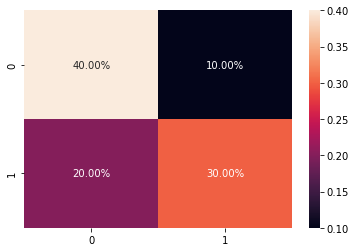

In [15]:
ac = accuracy_score(Y_test,clf_rf.predict(X_test))
print('Accuracy is: ', ac)

# we get the true negative, false pos, false negative and true pos 
# we see the percentage of the represented data in each quadrant 
cm = confusion_matrix(Y_test,clf_rf.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

<AxesSubplot:>

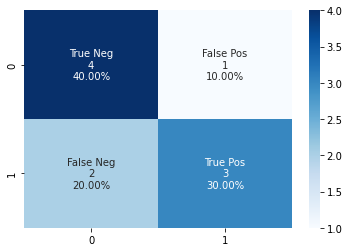

In [16]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [17]:
# Get the predictions
y_pred = clf_rf.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)

print("Summary: Random Forest with RNA")
print('Precision: %.3f' % precision_score(Y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(Y_test, y_pred))
print('F1 Score: %.3f' % f1_score(Y_test, y_pred))
print('Recall: %.3f' % recall_score(Y_test, y_pred))
print('Roc-score: %.3f' % roc_auc_score(Y_test, y_pred))

Summary: Random Forest with RNA
Precision: 0.750
Accuracy: 0.700
F1 Score: 0.667
Recall: 0.600
Roc-score: 0.700


<AxesSubplot:title={'center':'Feature Importance: Random Forest with RNA'}, ylabel='refGene'>

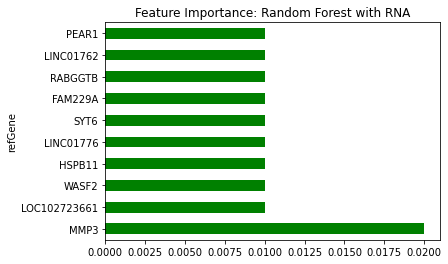

In [18]:
feat_imp = pd.Series(clf_rf.feature_importances_, index = df_T.iloc[:, 1:].columns)
feat_imp.nlargest(10).plot(kind='barh', 
                           color='green',
                           title='Feature Importance: Random Forest with RNA')

### SVM with RNA only

In [19]:
# define models and parameters
model = sklearn.svm.SVC()
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto'] # for poly, rbf, sigmoid

# define grid search
grid = dict(kernel=kernel, gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.865079 using {'gamma': 'scale', 'kernel': 'linear'}


In [20]:
clf_svm = sklearn.svm.SVC(kernel=grid_result.best_params_.get('kernel'), 
                  gamma=grid_result.best_params_.get('gamma'))     
clf_svm.fit(X_train,Y_train)

SVC(kernel='linear')

Accuracy is:  0.8


<AxesSubplot:>

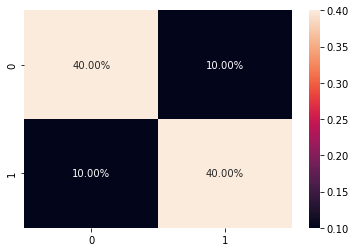

In [21]:
ac = accuracy_score(Y_test,clf_svm.predict(X_test))
print('Accuracy is: ', ac)

# we get the true negative, false pos, false negative and true pos 
# we see the percentage of the represented data in each quadrant 
cm = confusion_matrix(Y_test, clf_svm.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

<AxesSubplot:>

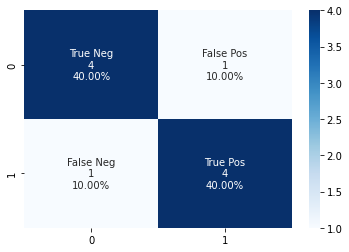

In [22]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [23]:
# Get the predictions
y_pred = clf_svm.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)

print("Summary: Support Vector Machine with RNA")
print('Precision: %.3f' % precision_score(Y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(Y_test, y_pred))
print('F1 Score: %.3f' % f1_score(Y_test, y_pred))
print('Recall: %.3f' % recall_score(Y_test, y_pred))
print('Roc-score: %.3f' % roc_auc_score(Y_test, y_pred))

Summary: Support Vector Machine with RNA
Precision: 0.800
Accuracy: 0.800
F1 Score: 0.800
Recall: 0.800
Roc-score: 0.800


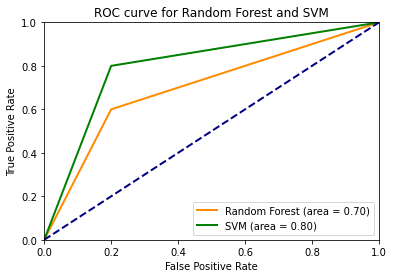

In [24]:
fpr_rf, tpr_rf, _ = roc_curve(Y_test, clf_rf.predict(X_test), pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(Y_test, clf_svm.predict(X_test), pos_label=1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", lw=2,
         label="Random Forest (area = %0.2f)" % roc_auc_rf)
plt.plot(fpr_svm, tpr_svm, color="green", lw=2,
         label="SVM (area = %0.2f)" % roc_auc_svm)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Random Forest and SVM")
plt.legend(loc="lower right")
plt.show()

<AxesSubplot:title={'center':'Feature Importance: SVM with RNA'}, ylabel='refGene'>

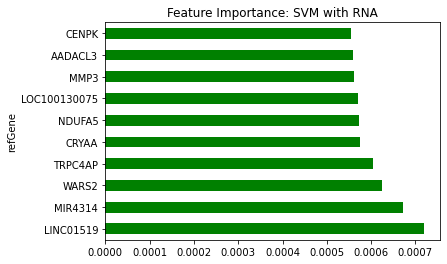

In [25]:
feat_imp = pd.Series(list(clf_svm.coef_[0]), index = df_T.iloc[:, 1:].columns)
feat_imp.nlargest(10).plot(kind='barh', 
                           color='green',
                           title='Feature Importance: SVM with RNA')

### Preparing ChIP-seq data

In [26]:
df = pd.read_csv("data/H3K122ac_counts.txt", sep="\t", index_col=0)

In [27]:
print(df.shape)

(2240520, 29)


In [28]:
df_T = df.T
df_T["class"] = df_T.apply(lambda x: change_labels(x.name), axis=1)

start
end
Y-15T
Y-17T
Y-13A
Y-18T
Y-14A
Y-19T
Y-15A
Y-16A
O-8A
O-10T
O-6A
O-11T
O-7A
O-13T
O-14T
O-9A
O-10A
O-11A
AD-1T
AD-1A
AD-2T
AD-2A
AD-5T
AD-3A
AD-5A
AD-8T
AD-7T


In [29]:
df_T.fillna(0)

chrom,chr1,chr1,chr1,chr1,chr1,chr1,chr1,chr1,chr1,chr1,...,chrY,chrY,chrY,chrY,chrY,chrY,chrY,chrY,chrY,class
start,713810,713860,713861,713882,713885,713891,713904,713938,713944,713949,...,22738064,22738088,22738113,22738235,23764353,23764935,23765114,23765197,23765201,0
end,713860,713861,713882,713885,713891,713904,713938,713944,713949,713973,...,22738088,22738113,22738235,22738243,23764935,23765114,23765197,23765201,23765332,0
Y-15T,0,0,0,0,0,0,0,0,0,0,...,20,20,20,0,16,16,16,0,0,0
Y-17T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,20,20,20,0
Y-13A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Y-18T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Y-14A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Y-19T,0,0,0,0,0,0,0,0,21,21,...,0,0,0,0,0,0,0,0,0,0
Y-15A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Y-16A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_T.groupby('class').size()

class
0    20
1     9
dtype: int64

In [31]:
# Get labels for training data
Y = df_T["class"].values

# Get training data as numpy array
X = df_T.drop(['class'], axis=1).astype(float).values
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)

In [32]:
X_train

array([[-0.27217331, -0.27217761, -0.27218027, ..., -0.2721659 ,
        -0.2721658 , -0.27216565],
       [-0.27217331, -0.27217761, -0.27218027, ..., -0.2721659 ,
        -0.2721658 , -0.27216565],
       [-0.27217331, -0.27217761, -0.2721084 , ..., -0.2721659 ,
        -0.2721658 , -0.27216565],
       ...,
       [-0.27217331, -0.27217761, -0.27218027, ..., -0.2721659 ,
        -0.2721658 , -0.27216565],
       [-0.27217331, -0.27217761, -0.27218027, ..., -0.2721659 ,
        -0.2721658 , -0.27216565],
       [-0.27217331, -0.27217761, -0.27218027, ..., -0.2721659 ,
        -0.2721658 , -0.27216565]])

In [33]:
Y_train

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0])

### Random Forest with ChIP-seq only

In [34]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 50, 100, 500, 1000]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators, max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.716931 using {'max_features': 'log2', 'n_estimators': 10}


In [35]:
clf_rf = RandomForestClassifier(random_state=43, 
                                n_estimators=grid_result.best_params_.get('n_estimators'), 
                                max_features=grid_result.best_params_.get('max_features'))     
clf_rf.fit(X_train,Y_train)

RandomForestClassifier(max_features='log2', n_estimators=10, random_state=43)

Accuracy is:  0.4


<AxesSubplot:>

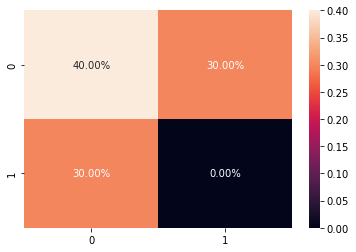

In [36]:
ac = accuracy_score(Y_test,clf_rf.predict(X_test))
print('Accuracy is: ', ac)

cm = confusion_matrix(Y_test,clf_rf.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

<AxesSubplot:>

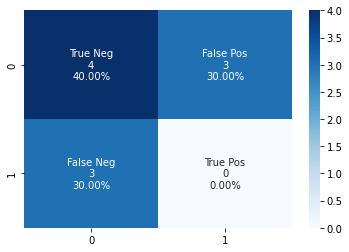

In [37]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [38]:
# Get the predictions
y_pred = clf_rf.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)
print()
print("Summary: Random Forest with ChIP-seq")
print('Precision: %.3f' % precision_score(Y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(Y_test, y_pred))
print('F1 Score: %.3f' % f1_score(Y_test, y_pred))
print('Recall: %.3f' % recall_score(Y_test, y_pred))
print('Roc-score: %.3f' % roc_auc_score(Y_test, y_pred))


Summary: Random Forest with ChIP-seq
Precision: 0.000
Accuracy: 0.400
F1 Score: 0.000
Recall: 0.000
Roc-score: 0.286


### SVM with ChIP-seq only

In [39]:
# define models and parameters
model = sklearn.svm.SVC()
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto'] # for poly, rbf, sigmoid

# define grid search
grid = dict(kernel=kernel, gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.698413 using {'gamma': 'scale', 'kernel': 'poly'}


In [40]:
clf_svm = sklearn.svm.SVC(kernel=grid_result.best_params_.get('kernel'), 
                          gamma=grid_result.best_params_.get('gamma'))     
clf_svm.fit(X_train,Y_train)

SVC(kernel='poly')

Accuracy is:  0.7


<AxesSubplot:>

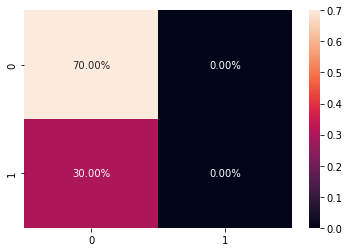

In [41]:
ac = accuracy_score(Y_test,clf_svm.predict(X_test))
print('Accuracy is: ', ac)

cm = confusion_matrix(Y_test, clf_svm.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

<AxesSubplot:>

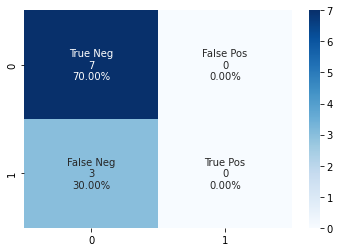

In [42]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [43]:
# Get the predictions
y_pred = clf_svm.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)

print("Summary: Support Vector Machine with ChIP-seq")
print('Precision: %.3f' % precision_score(Y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(Y_test, y_pred))
print('F1 Score: %.3f' % f1_score(Y_test, y_pred))
print('Recall: %.3f' % recall_score(Y_test, y_pred))
print('Roc-score: %.3f' % roc_auc_score(Y_test, y_pred))

Summary: Support Vector Machine with ChIP-seq
Precision: 0.000
Accuracy: 0.700
F1 Score: 0.000
Recall: 0.000
Roc-score: 0.500


/home/christina/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


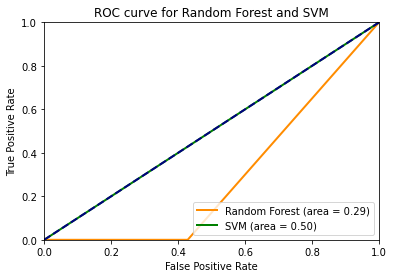

In [44]:
fpr_rf, tpr_rf, _ = roc_curve(Y_test, clf_rf.predict(X_test), pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(Y_test, clf_svm.predict(X_test), pos_label=1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", lw=2,
         label="Random Forest (area = %0.2f)" % roc_auc_rf)
plt.plot(fpr_svm, tpr_svm, color="green", lw=2,
         label="SVM (area = %0.2f)" % roc_auc_svm)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Random Forest and SVM")
plt.legend(loc="lower right")
plt.show()

As we realized, when searching for the parameters with the best accuracy, our model only predicts for the negative class and precision, recall, and F1 score are 0. Therefore, we searched for parameters that maximize the F1 score in the following section.

In [45]:
# define models and parameters
model = sklearn.svm.SVC()
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto'] # for poly, rbf, sigmoid

# define grid search
grid = dict(kernel=kernel, gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.218519 using {'gamma': 'scale', 'kernel': 'poly'}


In [46]:
clf_svm = sklearn.svm.SVC(kernel=grid_result.best_params_.get('kernel'), 
                          gamma=grid_result.best_params_.get('gamma'))     
clf_svm.fit(X_train,Y_train)

SVC(kernel='poly')

Accuracy is:  0.7


<AxesSubplot:>

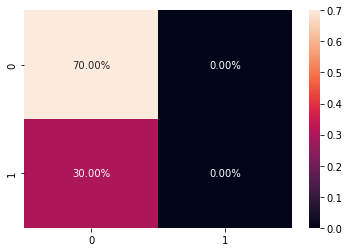

In [47]:
ac = accuracy_score(Y_test,clf_svm.predict(X_test))
print('Accuracy is: ', ac)

cm = confusion_matrix(Y_test, clf_svm.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

<AxesSubplot:>

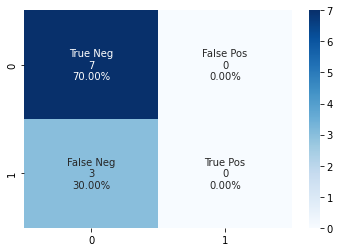

In [48]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [49]:
# Get the predictions
y_pred = clf_svm.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)

print("Summary: Support Vector Machine with ChIP-seq")
print('Precision: %.3f' % precision_score(Y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(Y_test, y_pred))
print('F1 Score: %.3f' % f1_score(Y_test, y_pred))
print('Recall: %.3f' % recall_score(Y_test, y_pred))
print('Roc-score: %.3f' % roc_auc_score(Y_test, y_pred))

Summary: Support Vector Machine with ChIP-seq
Precision: 0.000
Accuracy: 0.700
F1 Score: 0.000
Recall: 0.000
Roc-score: 0.500


/home/christina/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


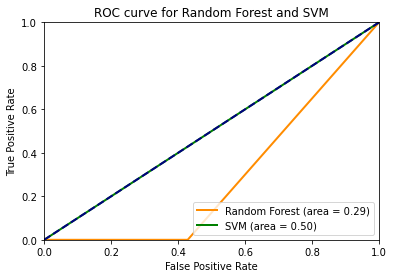

In [50]:
fpr_rf, tpr_rf, _ = roc_curve(Y_test, clf_rf.predict(X_test), pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(Y_test, clf_svm.predict(X_test), pos_label=1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", lw=2,
         label="Random Forest (area = %0.2f)" % roc_auc_rf)
plt.plot(fpr_svm, tpr_svm, color="green", lw=2,
         label="SVM (area = %0.2f)" % roc_auc_svm)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Random Forest and SVM")
plt.legend(loc="lower right")
plt.show()